In [1]:
# from sst and rainfall ---> rainfall
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow.compat.v1 as tf
import xarray as xr
import numpy as np
import pandas as pd
import scipy as sc
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import seaborn as sns

add_data = "/home/cccr/roxy/matin/MTech_project/data/"

In [31]:
def filter_signal_scipy(signal,sample_freq,ltime_period,htime_period,keep_mean):
    filter_signal=np.zeros(signal.shape)
    if any(np.isnan(signal)):
        raise ValueError('There is NaN in the signal')
    else:
        hf=1./ltime_period
        lf=1./htime_period

        temp_fft = sc.fftpack.fft(signal)

        fftfreq = np.fft.fftfreq(len(signal),sample_freq) ### daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
          
        i1=(np.abs(fftfreq) >= lf) & (np.abs(fftfreq) <= hf)  
        inv_fft=np.zeros(temp_fft.size,dtype=complex)
        inv_fft[i1]=temp_fft[i1]
        if keep_mean:
            inv_fft[0]=temp_fft[0]
        filter_signal= np.real_if_close(sc.fftpack.ifft(inv_fft))
    
    return filter_signal


rf = xr.open_dataarray(add_data + "rfbobmm_daily_1998-2019.nc")[:-30]
rf = rf.interpolate_na(dim="time")
sst = xr.open_dataarray(add_data + "tmpC_sstbob_1998-2020.nc")[:-731]


sample_freq = 1
ltime_period = 30
htime_period = 60
keep_mean = 0

filtered_rf = rf
for i in range(0,39):
    for j in range(0,25):
        filtered_rf[:,j,i] = filter_signal_scipy(rf[:,j,i].values, sample_freq,
                                              ltime_period, htime_period, keep_mean)
filtered_sst = sst
for i in range(0,39):
    for j in range(0,25):
        if any(np.isnan(sst[:,j,i].values)):
            pass
        else:
            filtered_sst[:,j,i] = filter_signal_scipy(sst[:,j,i].values, sample_freq,
                                              ltime_period, htime_period, keep_mean)

In [32]:
rf = xr.open_dataarray(add_data + "rfbobmm_daily_1998-2019.nc")[:-30]
rf = rf.interpolate_na(dim="time")

new_time = rf.sel(time=slice("2017-06-20","2017-10-12")).time.data

rf_mean = filtered_rf.mean(dim = ['lon', 'lat']).sel(time=slice("2017-06-08","2017-09-30")).assign_coords(time=new_time)
rf_std = rf_mean.std().data
print("First Std Deviation for RF monsoon DATA = ",rf_std)


First Std Deviation for RF monsoon DATA =  2.290512800216675


In [4]:

def preprocess_data(sequence, n_steps, channels):
    """
    Function to preprocess the data and prepare it for model training.
    
    Parameters:
        sequence (xarray.Dataset): Data sequence to be preprocessed.
        n_steps (int): Number of time steps in the input sequence.
        channels (int): Number of channels in the input sequence.
    
    Returns:
        tuple: A tuple containing the preprocessed input sequence (X) and output sequence (y).
    """
    # Select data for Jun, Jul, Aug, Sept
    sequence = sequence.sel(time=slice("2017-06-01","2017-10-30"))
    sequence = sequence.where(sequence.time.dt.month.isin([6,7,8,9]), drop=True)
    max = sequence.max()
    min = sequence.min()
    
    # Max-min normalization
    sequence = (sequence-min)/(max - min)
    sequence = np.array(sequence)
    
    # Exponential Space Transform
    valid_pts = np.where(sequence==sequence)
    sequence[valid_pts] = np.exp(sequence[valid_pts])
    sequence[valid_pts] = np.power(sequence[valid_pts],7)
    invalid_pts = np.where(sequence != sequence)
    sequence[invalid_pts] = 0
    
    # Prepare input and output sequences
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix + lead_time > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lead_time]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def create_input(channels, n_steps):
    """
    Function to create the input for the model.
    
    Parameters:
        channels (list): List of channels to be used in the input.
        n_steps (int): Number of time steps in the input sequence.
        
    Returns:
        numpy.ndarray: The input for the model.
    """
    stack = []
    for i in range(len(channels)):
        channel_data = xr.open_dataarray(f"/home/cccr/roxy/matin/MTech_project/data/{channels[i]}")
        input, _ = preprocess_data(channel_data, n_steps=n_steps, channels=channels[i])
        input = np.expand_dims(input, axis=2)
        print(f"Adding channel {i} with shape: {input.shape}")
        stack.append(input)
    out = np.dstack(stack)
    return out

def In_Out(lead_time, channels, steps):
    input = create_input(channels, steps)
    channel_data = xr.open_dataarray(add_data + channels[0])
    _, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
    target = np.expand_dims(target, axis=1)
    
    # Roll axes for input and target
    x = np.rollaxis(input, 4, 2)
    x = np.rollaxis(x, 4, 2)

    y = np.rollaxis(target, 3, 1)
    y = np.rollaxis(y, 3, 1)

    # Assert that input and target shapes are consistent
    assert input.shape[0] == target.shape[0]
    assert input.shape[-1] == target.shape[-1]
    assert input.shape[-2] == target.shape[-2]


    # Print shape of input and target
    print("INPUT SHAPE --> ", input.shape)
    print("TARGET SHAPE --> ", target.shape)

    # Delete original input and target variables to free up memory
    del input
    del target
    return x,y



In [5]:
sequence = channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_13lag.nc")
sequence = sequence.sel(time=slice("2017-06-01","2017-10-30"))
sequence = sequence.where(sequence.time.dt.month.isin([6,7,8,9]), drop=True)
max = sequence.max()
min = sequence.min()


In [6]:
lead_time = 0
channels = ["FilteredrfBOB_13lag.nc","FilteredSSTBOB_13.nc"]
steps = 7
x,y = In_Out(lead_time, channels, steps)

save_path = "/home/cccr/roxy/matin/MTech_project/model/Conv-LSTM/7in1out/"
model_path = save_path + "ConvLstm_sst13rf_rf_0bob.h5"

model = tf.keras.models.load_model(model_path)
pred = model.predict(x)

actual = y.flatten()
prediction = pred.flatten()
corr = np.corrcoef(actual,prediction)
print(corr[0,1])

predicted = []
for i in range(0,115):
    predicted.append(pred[i,:,:,0])
    
sequence = np.array(predicted)
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan


pred_seq = xr.DataArray(sequence,
                  dims=('time', 'lat','lon'),
                  coords={'time': channel_data.sel(time=slice("2017-06-20","2017-10-12")).time.data,
                          'lat': channel_data.sel(time=slice("2017-06-20","2017-10-12")).lat.data ,
                          'lon': channel_data.sel(time=slice("2017-06-20","2017-10-12")).lon.data},
                  name='rf prediction')


pred_seq1 = pred_seq*(max - min)+min 


Adding channel 0 with shape: (115, 7, 1, 25, 39)
Adding channel 1 with shape: (115, 7, 1, 25, 39)
INPUT SHAPE -->  (115, 7, 2, 25, 39)
TARGET SHAPE -->  (115, 1, 25, 39)


2023-03-27 13:08:24.475923: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


4/4 [==============================] - 4s 83ms/step
0.8984904719272417


In [7]:
pred_seq1

<xarray.DataArray (time: 115, lat: 25, lon: 39)>
array([[[ 1.83397092e+00,  7.01409424e+00,  8.65868914e+00, ...,
         -3.45818574e-01,  2.32834953e+00,  1.56984249e+00],
        [ 2.49092370e+00,  5.08499453e+00,  5.79521329e+00, ...,
         -7.25485942e-01,  2.66745957e+00,  3.16901158e+00],
        [ 1.08956928e+00,  1.97967495e+00,  1.86020443e+00, ...,
         -7.87437025e-01,  1.33134979e+00,  2.18967521e+00],
        ...,
        [ 8.16088989e-01,  8.04455199e-01,  8.21836909e-01, ...,
          1.25925714e+01,  1.19379983e+01,  9.91545463e+00],
        [ 1.67220720e+00,  2.56646287e+00,  1.76991035e+00, ...,
          1.14786130e+01,  1.13429219e+01,  9.08579984e+00],
        [ 4.83956921e-01,  3.03449301e+00,  2.86191171e+00, ...,
          9.90390706e+00,  8.37324743e+00,  3.98105475e+00]],

       [[ 1.74193522e+00,  6.86115358e+00,  8.62619040e+00, ...,
         -2.76745818e-01,  2.13155224e+00,  1.26724324e+00],
        [ 2.31721006e+00,  4.74553387e+00,  5.59182889e+00, ...,
         -4.50378989e-01,  2.48808423e+00,  2.89793392e+00],
        [ 1.19571612e+00,  1.92602961e+00,  1.91466597e+00, ...,
         -3.92784830e-01,  1.18446744e+00,  1.97163360e+00],
...
        [ 2.90298060e+00,  2.53417105e+00,  8.27234206e-01, ...,
          3.25842505e-02,  2.69828567e+00,  3.16399365e+00],
        [ 3.27939464e+00,  3.41616065e+00,  1.28113021e+00, ...,
          4.02330708e-01,  3.50582821e+00,  3.04940311e+00],
        [ 6.30971474e-01,  2.13104067e+00,  1.18459390e+00, ...,
          1.37902304e+00,  1.99806254e+00, -1.21456497e+00]],

       [[-6.95084554e+00, -4.57883985e+00, -4.72955319e+00, ...,
         -1.81113010e+00, -2.60521676e+00, -4.47263266e+00],
        [-2.94985343e+00, -2.50068509e+00, -2.29263912e+00, ...,
         -1.67165682e+00, -2.40042699e+00, -2.63877312e+00],
        [-1.65562587e+00, -1.56113006e+00, -4.41527192e-01, ...,
         -7.81010850e-01, -2.00534657e+00, -1.72423879e+00],
        ...,
        [ 2.91234971e+00,  2.54565539e+00,  8.76792773e-01, ...,
         -1.17659996e+00,  1.55497837e+00,  2.15143429e+00],
        [ 3.32126249e+00,  3.43299631e+00,  1.29153970e+00, ...,
         -2.03547238e-03,  3.09343218e+00,  2.61879193e+00],
        [ 6.12267742e-01,  2.03926363e+00,  1.03936695e+00, ...,
          1.17013788e+00,  1.76822621e+00, -1.47931417e+00]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-06-20 2017-06-21 ... 2017-10-12
  * lat      (lat) float32 15.12 15.38 15.62 15.88 ... 20.38 20.62 20.88 21.12
  * lon      (lon) float32 84.12 84.38 84.62 84.88 ... 92.88 93.12 93.38 93.62

In [8]:
actual_0 = filtered_rf.sel(time=slice("2017-06-08","2017-09-30")).assign_coords(time=new_time)

In [9]:
actual_0

<xarray.DataArray (time: 115, lat: 25, lon: 39)>
array([[[ 2.66769767e+00,  4.78281021e+00,  5.62910366e+00, ...,
          4.19472367e-01,  3.22597075e+00,  4.12852573e+00],
        [ 1.26528025e+00,  2.91532779e+00,  2.45844483e+00, ...,
          1.34284806e+00,  1.30372071e+00,  2.24817419e+00],
        [-5.09690046e-01, -1.72646165e+00, -2.26535629e-02, ...,
          2.54319310e-01, -6.86135769e-01, -6.19095981e-01],
        ...,
        [-1.25762835e-01,  2.71553040e-01,  3.43364626e-01, ...,
          1.27293949e+01,  1.31396399e+01,  9.90577412e+00],
        [-8.79658759e-01,  7.12635040e-01,  1.33762336e+00, ...,
          1.30571661e+01,  1.05773468e+01,  7.11674595e+00],
        [ 3.10227418e+00,  2.24352980e+00,  2.33099532e+00, ...,
          1.28625727e+01,  6.35031414e+00,  5.36297703e+00]],

       [[ 2.91871071e+00,  4.84990358e+00,  5.66867447e+00, ...,
          6.26899660e-01,  3.37017846e+00,  4.23079538e+00],
        [ 1.84505820e+00,  3.26337647e+00,  2.68880272e+00, ...,
          1.37298357e+00,  1.23708141e+00,  2.13042569e+00],
        [-7.26571754e-02, -1.35017192e+00,  3.56372446e-01, ...,
          6.07594132e-01, -7.06689358e-01, -7.34064162e-01],
...
          5.78643739e-01,  2.29739833e+00,  2.50471562e-01],
        [ 3.68987346e+00,  5.28420353e+00,  4.53562617e-01, ...,
          1.91037312e-01,  1.47710133e+00,  6.23774417e-02],
        [ 2.34028149e+00,  2.47932887e+00, -1.37150586e+00, ...,
          1.51929033e+00,  3.54514271e-01, -1.49930620e+00]],

       [[-4.37954998e+00, -4.78249025e+00, -5.18767023e+00, ...,
         -1.05587073e-01,  1.17830670e+00,  1.23207796e+00],
        [-2.87320566e+00, -1.78000939e+00, -6.54719710e-01, ...,
         -8.60524595e-01, -1.13357258e+00, -1.49327159e+00],
        [-7.05327332e-01, -3.30144018e-02, -7.17039704e-02, ...,
         -6.11491024e-01, -6.75958693e-01, -1.95119607e+00],
        ...,
        [ 1.17736602e+00,  1.34615684e+00,  1.51577100e-01, ...,
         -6.71646535e-01,  1.10600841e+00, -1.10152185e+00],
        [ 3.36731601e+00,  5.16016579e+00,  1.77281886e-01, ...,
         -3.90518337e-01,  9.56179500e-01, -4.49970663e-01],
        [ 1.95930398e+00,  2.29913616e+00, -1.57677078e+00, ...,
          1.34154606e+00,  1.85106531e-01, -1.67160785e+00]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-06-20 2017-06-21 ... 2017-10-12
  * lon      (lon) float32 84.12 84.38 84.62 84.88 ... 92.88 93.12 93.38 93.62
  * lat      (lat) float32 15.12 15.38 15.62 15.88 ... 20.38 20.62 20.88 21.12

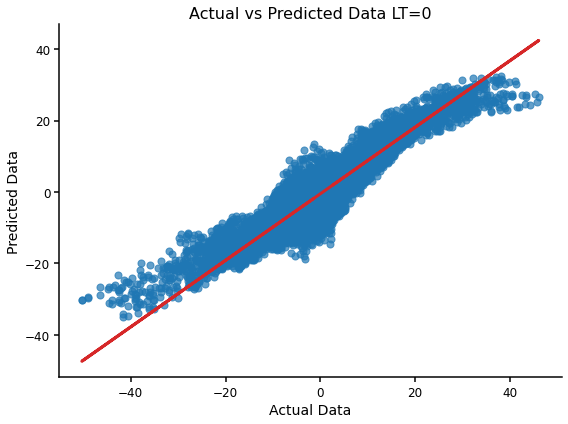

In [10]:

# Convert the arrays to DataFrames
actual_df = actual_0.rename("Actual").to_dataframe()
predicted_df = pred_seq1.rename("Predicted").to_dataframe()

# Merge the two DataFrames and drop any missing values
merged_df = actual_df.join(predicted_df).dropna()

# Calculate the correlation coefficient and intercept
corr_coeff = np.corrcoef(merged_df['Actual'], merged_df['Predicted'])
intercept = np.mean(merged_df['Predicted']) - corr_coeff[0, 1] * np.mean(merged_df['Actual'])

# Create a scatter plot with the regression line
fig, ax = plt.subplots(figsize=(8, 6))
merged_df.plot.scatter(x='Actual', y='Predicted', ax=ax, s=50, alpha=0.7, color='tab:blue')
ax.plot(merged_df['Actual'], corr_coeff[0, 1] * merged_df['Actual'] + intercept, linewidth=3, color='tab:red')
ax.set_xlabel('Actual Data', fontsize=14)
ax.set_ylabel('Predicted Data', fontsize=14)
ax.tick_params(labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=5)
ax.yaxis.set_tick_params(width=1.5, length=5)
plt.title('Actual vs Predicted Data LT=0', fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
lead_time = 1
channels = ["FilteredrfBOB_13lag.nc","FilteredSSTBOB_13.nc"]
steps = 7
x,y = In_Out(lead_time, channels, steps)

save_path = "/home/cccr/roxy/matin/MTech_project/model/Conv-LSTM/7in2out/"
model_path = save_path + "ConvLstm_sst13rf_rf_1bob.h5"

model = tf.keras.models.load_model(model_path)
pred = model.predict(x)

actual = y.flatten()
prediction = pred.flatten()
corr = np.corrcoef(actual,prediction)
print(corr[0,1])

predicted = []
for i in range(0,114):
    predicted.append(pred[i,:,:,0])
    
sequence = np.array(predicted)
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan


pred_seq = xr.DataArray(sequence,
                  dims=('time', 'lat','lon'),
                  coords={'time': channel_data.sel(time=slice("2017-06-21","2017-10-12")).time.data,
                          'lat': channel_data.sel(time=slice("2017-06-21","2017-10-12")).lat.data ,
                          'lon': channel_data.sel(time=slice("2017-06-21","2017-10-12")).lon.data},
                  name='rf prediction')


pred_seq2 = pred_seq*(max - min)+min 
pred_seq2

Adding channel 0 with shape: (114, 7, 1, 25, 39)
Adding channel 1 with shape: (114, 7, 1, 25, 39)
INPUT SHAPE -->  (114, 7, 2, 25, 39)
TARGET SHAPE -->  (114, 1, 25, 39)
4/4 [==============================] - 1s 91ms/step
0.7409062352252741


<xarray.DataArray (time: 114, lat: 25, lon: 39)>
array([[[-3.00517141e+00,  1.70593600e+00,  3.09973190e+00, ...,
         -2.61565561e-01,  7.42446637e-01, -3.80209754e+00],
        [-8.58090459e-01,  2.87830478e+00,  3.25336231e+00, ...,
         -2.79079474e-01,  1.64225479e+00, -1.68489428e+00],
        [-5.12893368e-01,  2.27254297e+00,  1.25041333e+00, ...,
         -1.72788872e+00,  2.35899681e-01, -2.49322428e+00],
        ...,
        [-9.64151081e-01,  1.35800865e+00, -7.20536982e-01, ...,
          1.91185357e+01,  1.87226075e+01,  1.33176830e+01],
        [ 4.23080699e-01,  3.63217324e+00,  2.36635477e+00, ...,
          1.68976141e+01,  1.57956344e+01,  1.00735339e+01],
        [-2.63054784e+00,  1.59759345e+00,  1.23873355e+00, ...,
          1.19602082e+01,  1.01829801e+01,  4.04153436e+00]],

       [[-2.99858430e+00,  1.78172807e+00,  3.17240286e+00, ...,
         -2.00673278e-03,  9.71380547e-01, -3.59428437e+00],
        [-1.04811670e+00,  2.79697171e+00,  3.29018349e+00, ...,
          1.96169427e-02,  1.86751003e+00, -1.49273556e+00],
        [-8.52480489e-01,  2.02117493e+00,  1.22083453e+00, ...,
         -1.38357681e+00,  4.31984227e-01, -2.35749290e+00],
...
        [ 1.80443747e-01,  1.99922937e+00, -1.55242771e+00, ...,
          1.11865313e-01,  2.60034111e+00,  1.30816205e-01],
        [ 1.84589785e+00,  4.64656043e+00,  2.14218589e+00, ...,
         -2.82545470e-01,  1.49331468e+00, -1.63168578e+00],
        [-1.33036257e+00,  2.59224804e+00,  1.33000478e+00, ...,
         -2.51598030e+00, -2.23235493e+00, -6.24196605e+00]],

       [[-8.88064649e+00, -4.70127630e+00, -4.36994894e+00, ...,
         -8.59355001e-01, -6.07917984e-01, -5.20690934e+00],
        [-7.20223658e+00, -3.83359902e+00, -4.10381737e+00, ...,
         -1.25780657e+00, -1.67616437e-02, -3.32868447e+00],
        [-6.45329983e+00, -3.54722040e+00, -3.95497210e+00, ...,
         -2.54371976e+00, -9.37871590e-01, -3.54776645e+00],
        ...,
        [ 3.21704002e-02,  1.84448386e+00, -1.68642323e+00, ...,
         -8.02122960e-01,  1.87821841e+00, -4.77250516e-01],
        [ 1.66589024e+00,  4.42687492e+00,  1.87858627e+00, ...,
         -7.35814954e-01,  1.19065220e+00, -1.89755583e+00],
        [-1.50682371e+00,  2.36322791e+00,  1.03803343e+00, ...,
         -2.68167559e+00, -2.25780959e+00, -6.25704859e+00]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-06-21 2017-06-22 ... 2017-10-12
  * lat      (lat) float32 15.12 15.38 15.62 15.88 ... 20.38 20.62 20.88 21.12
  * lon      (lon) float32 84.12 84.38 84.62 84.88 ... 92.88 93.12 93.38 93.62

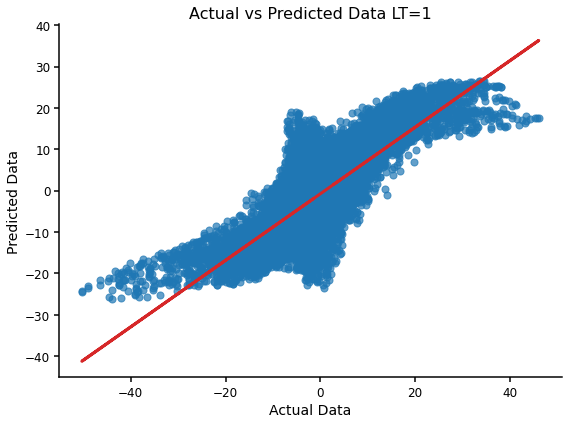

In [12]:

# Convert the arrays to DataFrames
actual_df = actual_0.rename("Actual").to_dataframe()
predicted_df = pred_seq2.rename("Predicted").to_dataframe()

# Merge the two DataFrames and drop any missing values
merged_df = actual_df.join(predicted_df).dropna()

# Calculate the correlation coefficient and intercept
corr_coeff = np.corrcoef(merged_df['Actual'], merged_df['Predicted'])
intercept = np.mean(merged_df['Predicted']) - corr_coeff[0, 1] * np.mean(merged_df['Actual'])

# Create a scatter plot with the regression line
fig, ax = plt.subplots(figsize=(8, 6))
merged_df.plot.scatter(x='Actual', y='Predicted', ax=ax, s=50, alpha=0.7, color='tab:blue')
ax.plot(merged_df['Actual'], corr_coeff[0, 1] * merged_df['Actual'] + intercept, linewidth=3, color='tab:red')
ax.set_xlabel('Actual Data', fontsize=14)
ax.set_ylabel('Predicted Data', fontsize=14)
ax.tick_params(labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=5)
ax.yaxis.set_tick_params(width=1.5, length=5)
plt.title('Actual vs Predicted Data LT=1', fontsize=16)
plt.tight_layout()
plt.show()


In [13]:
lead_time = 2
channels = ["FilteredrfBOB_13lag.nc","FilteredSSTBOB_13.nc"]
steps = 7
x,y = In_Out(lead_time, channels, steps)

save_path = "/home/cccr/roxy/matin/MTech_project/model/Conv-LSTM/7in3out/"
model_path = save_path + "ConvLstm_sst13rf_rf_2bob.h5"

model = tf.keras.models.load_model(model_path)
pred = model.predict(x)

actual = y.flatten()
prediction = pred.flatten()
corr = np.corrcoef(actual,prediction)
print(corr[0,1])

predicted = []
for i in range(0,113):
    predicted.append(pred[i,:,:,0])
    
sequence = np.array(predicted)
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan


pred_seq = xr.DataArray(sequence,
                  dims=('time', 'lat','lon'),
                  coords={'time': channel_data.sel(time=slice("2017-06-22","2017-10-12")).time.data,
                          'lat': channel_data.sel(time=slice("2017-06-22","2017-10-12")).lat.data ,
                          'lon': channel_data.sel(time=slice("2017-06-22","2017-10-12")).lon.data},
                  name='rf prediction')


pred_seq3 = pred_seq*(max - min)+min 
pred_seq3

Adding channel 0 with shape: (113, 7, 1, 25, 39)
Adding channel 1 with shape: (113, 7, 1, 25, 39)
INPUT SHAPE -->  (113, 7, 2, 25, 39)
TARGET SHAPE -->  (113, 1, 25, 39)
4/4 [==============================] - 1s 81ms/step
0.7536813703505152


<xarray.DataArray (time: 113, lat: 25, lon: 39)>
array([[[-9.89947746e-01,  2.46841484e+00,  3.52194537e+00, ...,
          4.71708103e-01,  1.28394095e+00, -1.55609489e+00],
        [ 4.82037116e-01,  2.89475532e+00,  3.65170467e+00, ...,
          1.18024847e+00,  2.88297783e+00,  1.95255051e+00],
        [-3.09503215e-01,  9.64241630e-01,  1.52875061e+00, ...,
          3.16094662e-01,  2.27369255e+00,  2.26266230e+00],
        ...,
        [ 8.32522293e-01,  1.28113021e+00,  7.09786954e-01, ...,
          1.69769757e+01,  1.54991682e+01,  1.18236262e+01],
        [ 1.64255368e+00,  3.02080721e+00,  2.07502719e+00, ...,
          1.62620666e+01,  1.42443340e+01,  1.01868944e+01],
        [-3.28321906e-01,  2.71476495e+00,  2.27515827e+00, ...,
          1.27811837e+01,  1.03191023e+01,  5.38580044e+00]],

       [[-6.29018598e-01,  2.84562210e+00,  3.80997940e+00, ...,
          3.29820695e-01,  1.05002359e+00, -1.84390474e+00],
        [ 7.78543575e-01,  3.19997563e+00,  3.84355875e+00, ...,
          9.76501944e-01,  2.52665277e+00,  1.54044763e+00],
        [-7.46259555e-02,  1.20748211e+00,  1.68320297e+00, ...,
          6.92157453e-02,  1.80324829e+00,  1.72220836e+00],
...
        [ 1.43399040e+00,  1.47259918e+00, -2.50558294e-01, ...,
          9.21517340e-01,  2.82943596e+00,  2.65653852e+00],
        [ 3.17040258e+00,  4.13232276e+00,  1.81477286e+00, ...,
          1.13987508e+00,  3.18384122e+00,  2.49105590e+00],
        [ 9.42916846e-01,  3.50883437e+00,  1.84911094e+00, ...,
          4.53331373e-02,  8.53824085e-01, -1.38339288e+00]],

       [[-5.28583978e+00, -3.10952778e+00, -3.37562199e+00, ...,
         -2.94139025e-01, -6.28196646e-01, -3.77918346e+00],
        [-3.16046010e+00, -1.90362563e+00, -2.28073805e+00, ...,
          3.80908209e-01,  8.49524640e-01, -4.36354064e-01],
        [-2.66070718e+00, -2.21248437e+00, -2.46425477e+00, ...,
         -1.95820851e-01,  5.66795946e-01,  1.96514302e-02],
        ...,
        [ 1.41318293e+00,  1.42958175e+00, -3.20303557e-01, ...,
         -2.74147758e-01,  1.70998828e+00,  1.57024485e+00],
        [ 3.17294891e+00,  4.10169784e+00,  1.72381203e+00, ...,
          3.10668626e-01,  2.51322563e+00,  1.86551550e+00],
        [ 9.49216567e-01,  3.47681845e+00,  1.74242954e+00, ...,
         -5.15031595e-01,  4.47572587e-01, -1.74642576e+00]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-06-22 2017-06-23 ... 2017-10-12
  * lat      (lat) float32 15.12 15.38 15.62 15.88 ... 20.38 20.62 20.88 21.12
  * lon      (lon) float32 84.12 84.38 84.62 84.88 ... 92.88 93.12 93.38 93.62

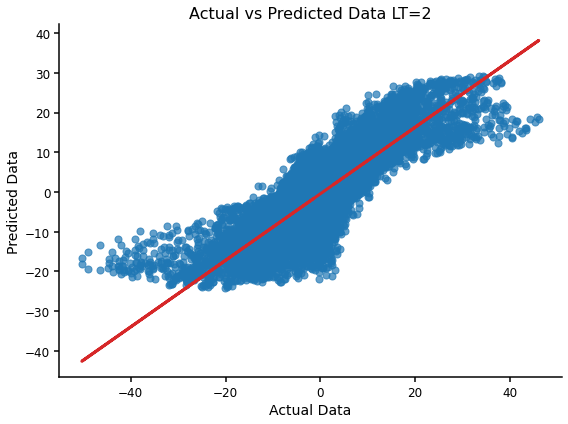

In [14]:

# Convert the arrays to DataFrames
actual_df = actual_0.rename("Actual").to_dataframe()
predicted_df = pred_seq3.rename("Predicted").to_dataframe()

# Merge the two DataFrames and drop any missing values
merged_df = actual_df.join(predicted_df).dropna()

# Calculate the correlation coefficient and intercept
corr_coeff = np.corrcoef(merged_df['Actual'], merged_df['Predicted'])
intercept = np.mean(merged_df['Predicted']) - corr_coeff[0, 1] * np.mean(merged_df['Actual'])

# Create a scatter plot with the regression line
fig, ax = plt.subplots(figsize=(8, 6))
merged_df.plot.scatter(x='Actual', y='Predicted', ax=ax, s=50, alpha=0.7, color='tab:blue')
ax.plot(merged_df['Actual'], corr_coeff[0, 1] * merged_df['Actual'] + intercept, linewidth=3, color='tab:red')
ax.set_xlabel('Actual Data', fontsize=14)
ax.set_ylabel('Predicted Data', fontsize=14)
ax.tick_params(labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=5)
ax.yaxis.set_tick_params(width=1.5, length=5)
plt.title('Actual vs Predicted Data LT=2', fontsize=16)
plt.tight_layout()
plt.show()


In [15]:
lead_time = 3
channels = ["FilteredrfBOB_13lag.nc","FilteredSSTBOB_13.nc"]
steps = 7
x,y = In_Out(lead_time, channels, steps)

save_path = "/home/cccr/roxy/matin/MTech_project/model/Conv-LSTM/7in4out/"
model_path = save_path + "ConvLstm_sst13rf_rf_3bob.h5"

model = tf.keras.models.load_model(model_path)
pred = model.predict(x)

actual = y.flatten()
prediction = pred.flatten()
corr = np.corrcoef(actual,prediction)
print(corr[0,1])

predicted = []
for i in range(0,112):
    predicted.append(pred[i,:,:,0])
    
sequence = np.array(predicted)
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan


pred_seq = xr.DataArray(sequence,
                  dims=('time', 'lat','lon'),
                  coords={'time': channel_data.sel(time=slice("2017-06-23","2017-10-12")).time.data,
                          'lat': channel_data.sel(time=slice("2017-06-23","2017-10-12")).lat.data ,
                          'lon': channel_data.sel(time=slice("2017-06-23","2017-10-12")).lon.data},
                  name='rf prediction')


pred_seq4 = pred_seq*(max - min)+min 
pred_seq4

Adding channel 0 with shape: (112, 7, 1, 25, 39)
Adding channel 1 with shape: (112, 7, 1, 25, 39)
INPUT SHAPE -->  (112, 7, 2, 25, 39)
TARGET SHAPE -->  (112, 1, 25, 39)
4/4 [==============================] - 1s 77ms/step
0.6830162375030839


<xarray.DataArray (time: 112, lat: 25, lon: 39)>
array([[[ 1.83398178e-01,  5.15425697e+00,  4.53797647e+00, ...,
          2.53412411e-03,  5.77602036e-01, -3.31032562e+00],
        [ 2.58291341e+00,  6.36486091e+00,  4.64523266e+00, ...,
         -4.05269312e-01,  9.29702378e-01, -2.50708252e+00],
        [ 1.15488864e+00,  4.19127343e+00,  2.07191182e+00, ...,
         -1.58699570e+00,  1.16618213e-02, -2.99831702e+00],
        ...,
        [-4.58880163e-01,  2.72435823e+00,  1.57139443e+00, ...,
          1.82998825e+01,  1.66972072e+01,  1.03708911e+01],
        [ 1.90651424e-02,  3.81246825e+00,  2.82171650e+00, ...,
          1.49958688e+01,  1.30086748e+01,  6.57945376e+00],
        [-2.13982491e+00,  2.27014609e+00,  2.30175965e+00, ...,
          1.01182757e+01,  7.72762955e+00,  5.93132916e-01]],

       [[ 2.21983966e-01,  5.19808486e+00,  4.64434748e+00, ...,
         -2.63514106e-01,  1.00294749e-01, -3.87655897e+00],
        [ 2.71649508e+00,  6.49135539e+00,  4.81079001e+00, ...,
         -7.28917450e-01,  3.02368629e-01, -3.24188801e+00],
        [ 1.59128224e+00,  4.63654181e+00,  2.52719882e+00, ...,
         -1.83160419e+00, -6.36416172e-01, -3.79999668e+00],
...
        [-3.01594077e-01,  2.61116444e+00,  5.99392401e-01, ...,
          1.23888300e+00,  2.71311530e+00, -8.63407285e-01],
        [ 6.18527227e-01,  4.08297112e+00,  2.11303244e+00, ...,
          1.03053239e+00,  2.48200293e+00, -1.44844784e+00],
        [-1.51373271e+00,  2.52514682e+00,  1.71040788e+00, ...,
          4.07498088e-01,  6.03772316e-01, -4.77256201e+00]],

       [[-8.01904764e+00, -3.61463200e+00, -3.80127272e+00, ...,
         -3.48879854e+00, -3.47028449e+00, -7.33698507e+00],
        [-5.60634955e+00, -2.50744464e+00, -3.64175644e+00, ...,
         -3.40795979e+00, -2.75682678e+00, -6.30821370e+00],
        [-4.24351194e+00, -1.42174300e+00, -2.67145004e+00, ...,
         -2.62672548e+00, -2.00876659e+00, -5.59688847e+00],
        ...,
        [-4.19156287e-01,  2.48163506e+00,  4.47670301e-01, ...,
         -6.15673110e-03,  1.52192208e+00, -1.92561717e+00],
        [ 5.34877745e-01,  3.97661160e+00,  1.95552793e+00, ...,
          2.85009910e-01,  1.76146665e+00, -2.09314605e+00],
        [-1.57914405e+00,  2.42784602e+00,  1.55210441e+00, ...,
          4.63792587e-02,  2.32738325e-01, -5.12404732e+00]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-06-23 2017-06-24 ... 2017-10-12
  * lat      (lat) float32 15.12 15.38 15.62 15.88 ... 20.38 20.62 20.88 21.12
  * lon      (lon) float32 84.12 84.38 84.62 84.88 ... 92.88 93.12 93.38 93.62

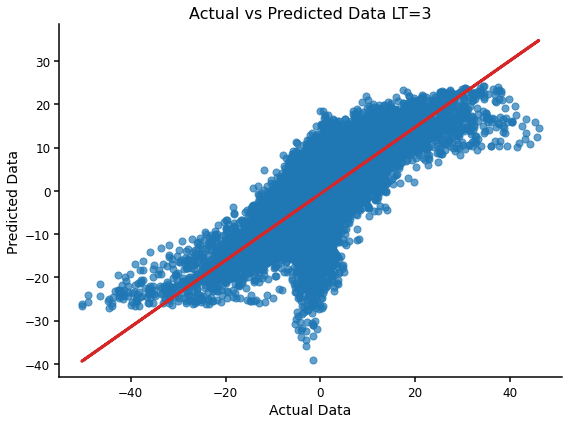

In [16]:

# Convert the arrays to DataFrames
actual_df = actual_0.rename("Actual").to_dataframe()
predicted_df = pred_seq4.rename("Predicted").to_dataframe()

# Merge the two DataFrames and drop any missing values
merged_df = actual_df.join(predicted_df).dropna()

# Calculate the correlation coefficient and intercept
corr_coeff = np.corrcoef(merged_df['Actual'], merged_df['Predicted'])
intercept = np.mean(merged_df['Predicted']) - corr_coeff[0, 1] * np.mean(merged_df['Actual'])

# Create a scatter plot with the regression line
fig, ax = plt.subplots(figsize=(8, 6))
merged_df.plot.scatter(x='Actual', y='Predicted', ax=ax, s=50, alpha=0.7, color='tab:blue')
ax.plot(merged_df['Actual'], corr_coeff[0, 1] * merged_df['Actual'] + intercept, linewidth=3, color='tab:red')
ax.set_xlabel('Actual Data', fontsize=14)
ax.set_ylabel('Predicted Data', fontsize=14)
ax.tick_params(labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=5)
ax.yaxis.set_tick_params(width=1.5, length=5)
plt.title('Actual vs Predicted Data LT=3', fontsize=16)
plt.tight_layout()
plt.show()


In [17]:
filtered_rf

<xarray.DataArray (time: 7670, lat: 25, lon: 39)>
array([[[-2.537407  , -2.3802953 , -2.7188292 , ..., -1.734248  ,
         -1.1959472 , -2.0187285 ],
        [-2.5103595 , -1.919431  , -2.3931284 , ..., -0.5831521 ,
         -1.1716907 , -1.4881989 ],
        [-2.5657222 , -2.5050924 , -2.188819  , ..., -0.57586074,
         -0.8462413 , -0.83342624],
        ...,
        [-1.160703  , -0.21429299,  0.0239708 , ..., -2.7884939 ,
         -2.1654494 , -2.4001997 ],
        [-1.045076  , -0.62370753, -0.7219677 , ..., -2.3919327 ,
         -1.6051458 , -2.0156758 ],
        [-1.4278939 , -1.2313619 , -1.7764093 , ..., -2.27576   ,
         -1.5318692 , -2.1616726 ]],

       [[-2.515389  , -2.3575118 , -2.8264887 , ..., -2.0395029 ,
         -1.3567308 , -2.0833347 ],
        [-2.5790367 , -2.021885  , -2.4998784 , ..., -0.85648507,
         -1.3805143 , -1.6787354 ],
        [-2.7677116 , -2.7040467 , -2.271498  , ..., -0.8226862 ,
         -1.1288236 , -1.1188098 ],
...
        [-0.81468594, -0.04870113,  0.11818606, ..., -3.0592144 ,
         -2.3442392 , -2.5291111 ],
        [-0.4900724 , -0.36453828, -0.26275542, ..., -2.3589735 ,
         -1.8972666 , -2.336245  ],
        [-0.8341257 , -0.7912602 , -1.2427677 , ..., -2.4915113 ,
         -1.8023982 , -2.4933283 ]],

       [[-2.4860735 , -2.3369772 , -2.5205915 , ..., -1.3607877 ,
         -0.9811471 , -1.8866647 ],
        [-2.3644197 , -1.7588377 , -2.2119298 , ..., -0.28535455,
         -0.9161513 , -1.2441609 ],
        [-2.2826304 , -2.2253976 , -2.0369093 , ..., -0.30444524,
         -0.5327554 , -0.5190573 ],
        ...,
        [-1.001413  , -0.13482556,  0.06768198, ..., -2.961719  ,
         -2.2838356 , -2.502789  ],
        [-0.7759375 , -0.49963874, -0.5030553 , ..., -2.4065921 ,
         -1.7735331 , -2.2093112 ],
        [-1.1457156 , -1.0272808 , -1.5360621 , ..., -2.4170282 ,
         -1.6870493 , -2.3635602 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2018-12-31
  * lon      (lon) float32 84.12 84.38 84.62 84.88 ... 92.88 93.12 93.38 93.62
  * lat      (lat) float32 15.12 15.38 15.62 15.88 ... 20.38 20.62 20.88 21.12

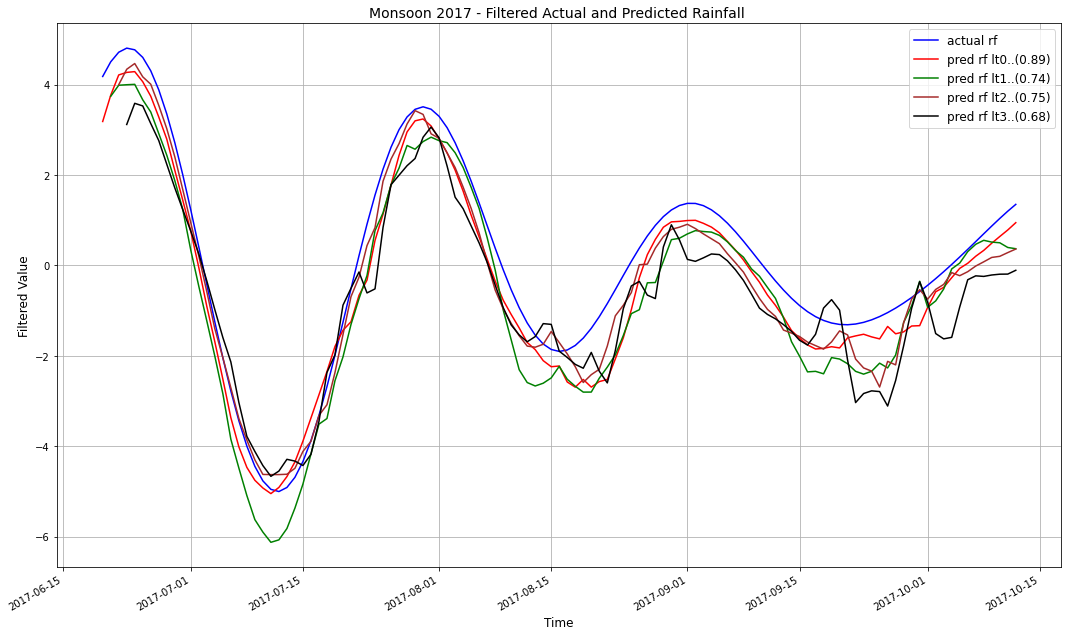

In [18]:
plt.figure(figsize=[18,10])

# Plot filtered rainfall data
Frf_mon = filtered_rf.isel(time=filtered_rf.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
new_time = Frf_mon.sel(time=slice("2017-06-20","2017-10-12")).time.data
rf_mean = Frf_mon.mean(dim = ['lon', 'lat']).sel(time=slice("2017-06-08","2017-09-30")).assign_coords(time=new_time)

filtered_rf = xr.DataArray(rf_mean, coords={"time":rf_mean.time},dims=["time"])
x = filtered_rf.time.data
y = filtered_rf.data
filtered_rf.plot(color = 'b', label='actual rf ')



pred_mean = pred_seq1.mean(dim = ['lon', 'lat'])
x = pred_mean.time.data
y = pred_mean.data
pred_mean.plot(color = 'r', label='pred rf lt0..(0.89)')

pred_mean = pred_seq2.mean(dim = ['lon', 'lat'])
y = pred_mean.data
pred_mean.plot(color = 'g', label='pred rf lt1..(0.74)')


pred_mean = pred_seq3.mean(dim = ['lon', 'lat'])
y = pred_mean.data
pred_mean.plot(color = 'brown', label='pred rf lt2..(0.75)')


pred_mean = pred_seq4.mean(dim = ['lon', 'lat'])
y = pred_mean.data
pred_mean.plot(color = 'black', label='pred rf lt3..(0.68)')

# Set axis labels and title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Filtered Value', fontsize=12)
plt.title("Monsoon 2017 - Filtered Actual and Predicted Rainfall ", fontsize=14)

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Add gridlines
plt.grid(True)

# Save figure
plt.savefig("MonsoonPred2017.png")


In [22]:
pred_seq1.mean(dim = ['lon', 'lat']).std()

<xarray.DataArray ()>
array(2.20272503)

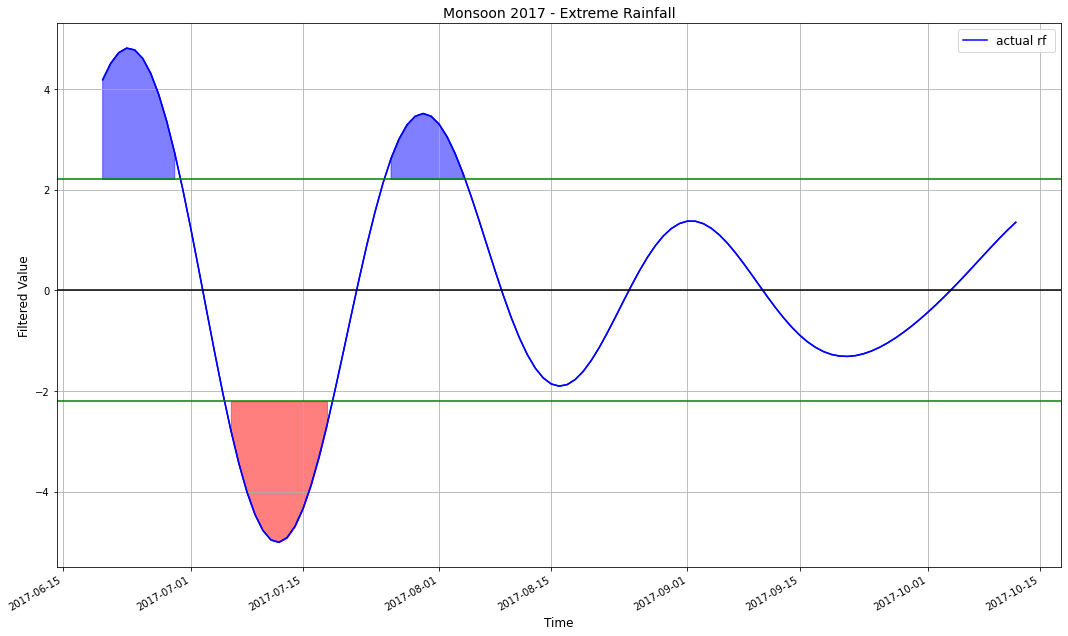

In [33]:
plt.figure(figsize=[18,10])

#
# Plot filtered rainfall data
Frf_mon = filtered_rf.isel(time=filtered_rf.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
new_time = Frf_mon.sel(time=slice("2017-06-20","2017-10-12")).time.data
rf_mean = Frf_mon.mean(dim = ['lon', 'lat']).sel(time=slice("2017-06-08","2017-09-30")).assign_coords(time=new_time)

filtered_rf = xr.DataArray(rf_mean, coords={"time":rf_mean.time},dims=["time"])
x = filtered_rf.time.data
y = filtered_rf.data
filtered_rf.plot(color = 'b', label='actual rf ')

sns.lineplot(x=x, y=y, color='b')
plt.axhline(y=0, color='black')
plt.axhline(y=2.202, color='g')
plt.axhline(y=-2.202, color='g')
above_threshold = y > 2.202
below_threshold = y < -2.202
plt.fill_between(x, y, 2.202, where=above_threshold, color='blue', alpha=0.5)
plt.fill_between(x, y, -2.202, where=below_threshold, color='red', alpha=0.5)

# Set axis labels and title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Filtered Value', fontsize=12)
plt.title("Monsoon 2017 - Extreme Rainfall", fontsize=14)

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Add gridlines
plt.grid(True)

# Save figure
plt.savefig("actExtremeRainFallPred2017.png")
